In [1]:
from langgraph.graph import START, END, StateGraph, MessagesState
from typing import List
import os 
from IPython.display import Image, display
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage

os.environ["GOOGLE_API_KEY"]  = os.getenv("GOOGLE_API_KEY")
os.environ["OPENAI_API_KEY"]  = os.getenv("OPENAI_API_KEY")

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chat_models import init_chat_model

gemini = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

llm = init_chat_model("openai:gpt-4.1", temperature=0.0)


In [3]:
from pydantic import BaseModel, Field
from typing import Literal

class PlanSchema(BaseModel):
    """A structured plan describing an individual task."""
    title: str = Field(..., description="A string describing the task")
    completed: Literal[True, False] = Field(..., description="Whether the task is completed")
    node: Literal["task_agent"] = Field(..., description="The node responsible for the task")

class State(MessagesState):
    plans: List[PlanSchema] = Field(default_factory=list)
    query:str
    current_task:PlanSchema
    

In [4]:
from langgraph.types import Command

class PlanList(BaseModel):
    plans: List[PlanSchema]

def planner(state: State) -> Command[Literal["supervisor"]]:
    """Generate structured plans from the user query using predefined task categories."""

    llm_with_structured_output = llm.with_structured_output(PlanList)

    prompt = """
You are an intelligent planning assistant.

Your job is to take any user input — written in natural language — and break it down into a structured plan of one or more discrete tasks.

Each task must match **one** of the following predefined task types:

- `create_task` — For creating a new task or item
- `update_task` — For modifying or updating existing items
- `get_all_task` — For retrieving or listing tasks or data
- `delete_task` — For removing or deleting an existing task or item

### Rules:
- Only use one of the above 4 task categories for each task node
- Do not invent or use any other task types
- Be concise and precise in the `title` field
- Always set `completed` to false
- Always set `node` to `"task_agent"`
- If no valid tasks can be identified from the query, return an empty list of plans
"""

    result = llm_with_structured_output.invoke([
        {"role": "system", "content": prompt},
        {"role": "user", "content": state["query"]}
    ])

    plans = result.plans or []
    plans_text = "\n".join([f"- {plan.title} ({plan.node})" for plan in plans])

    # Use AIMessage instead of dictionary
    message = AIMessage(content=f"Generated plans:\n{plans_text}")

    return Command(
        goto="supervisor",
        update={
            "plans": plans,
            "messages": state["messages"] + [message]
        }
    )

In [5]:

class AgentNode(BaseModel):
    node: Literal["task_agent"]

def supervisor(state: State):
    """Enhanced supervisor with priority-based task selection"""
    
    if len(state["plans"]) > 0:
        # Get all incomplete tasks
        incomplete_tasks = [task for task in state["plans"] if not task.completed]
        
        if not incomplete_tasks:
            # All tasks completed
            completion_message = AIMessage(
                content="🎉 All tasks have been completed successfully!"
            )
            return {
                "messages": state["messages"] + [completion_message]
            }
        
        # Select task based on priority (you can customize this logic)
        current_task = incomplete_tasks[0] 
        supervisor_prompt = f"""
You are an intelligent task supervisor with the following responsibilities:

1. Analyze the current task and determine the best agent to handle it
2. Consider the task type and complexity
3. Provide reasoning for your decision

Current Task Analysis:
- Title: {current_task.title}
- Type: {getattr(current_task, 'task_type', 'general')}
- Target Node: {current_task.node}
- Status: {'Pending' if not current_task.completed else 'Completed'}

Available Agents:
- task_agent: Specialized in handling all task operations (CRUD operations)

Instructions:
- Route to "task_agent" for all task-related operations
- Provide clear reasoning for your routing decision
"""
        llm_with_structured_output = llm.with_structured_output(AgentNode)
         
        messages = [
            SystemMessage(content=supervisor_prompt),
            HumanMessage(content=f"Please route this task: {current_task.title}")
        ]
        try:
            result = llm_with_structured_output.invoke(messages)
            
            routing_message = AIMessage(
                content=f"📋 Routing task '{current_task.title}' to {result.node}"
            )
            
            print(result.node, "result.node")
            return Command(
                goto=result.node,
                update={
                    "current_task": current_task,
                    "messages": state["messages"] + [routing_message]
                }
            )
            
        except Exception as e:
            # Robust error handling
            error_message = AIMessage(
                content=f"⚠️ Routing error occurred, using default agent: {str(e)}"
            )
            
            return Command(
                goto="task_agent",
                update={
                    "current_task": current_task,
                    "messages": state["messages"] + [error_message]
                }
            )
    else:
        no_plans_prompt = """
    You are a helpful executive assistant.

    The user has not defined any tasks yet. Your role is to:
    - Politely acknowledge their message
    - Encourage them to describe what they want to accomplish
    - Do NOT generate plans or take actions yourself
    - Ask helpful clarifying questions if needed

    Be supportive, but wait for the planner to handle task generation.
    """

        messages = [
            SystemMessage(content=no_plans_prompt),
            HumanMessage(content=state["query"])
        ]
        
        reply = llm.invoke(messages)
        
        # Ensure reply is an AIMessage
        if isinstance(reply, str):
            reply = AIMessage(content=reply)
        return {
            "messages": state["messages"] + [reply]
        }


In [6]:
def should_supervisor_end(state: State) -> Literal["task_agent", "__end__"]:
    """Route to agent or end the supervisor"""

    if len(state["plans"]) > 0:
        return "task_agent"
    else : 
        return END
    
                
                

In [7]:
from langchain.tools import tool

@tool
def create_task(title: str, description: str):
    """Create a new task with title and description"""
    print(f"Creating task: {title} - {description}")
    return f"✅ Task '{title}' created successfully"

@tool
def update_task(task_id: int, title: str = None, description: str = None):
    """Update an existing task by ID"""
    print(f"Updating task ID {task_id}")
    return f"✅ Task ID {task_id} updated successfully"

@tool
def get_all_tasks():
    """Retrieve all tasks"""
    print("Getting all tasks")
    return "📋 Retrieved all tasks successfully"

@tool
def delete_task(task_id: int):
    """Delete a task by ID"""
    print(f"Deleting task ID {task_id}")
    return f"🗑️ Task ID {task_id} deleted successfully"



In [8]:
tools  = [create_task, update_task, get_all_tasks, delete_task]

tools_by_name = {tool.name: tool for tool in tools}

def task_agent_node(state:State):
    """task agent to create , update, delete tasks"""

    llm_with_tools  = llm.bind_tools(tools)
    task_agent_prompt = f"""
        You are a task agent capable of executing the following task types:
        - create_task
        - update_task
        - get_all_tasks
        - delete_task

        Your job is to use the appropriate tool to complete the current task assigned to you.

        Current Task Analysis:
        - Title: {state["current_task"].title}

    message history :
        {state["messages"]}
    """

    messages = [
            SystemMessage(content=task_agent_prompt),
        ]
    
    reply = llm_with_tools.invoke(messages)
    # Ensure reply is an AIMessage
    if isinstance(reply, str):
        reply = AIMessage(content=reply)
    return {
        "messages": state["messages"] + [reply]
    }

    


In [9]:
def tool_handler(state: State):
    """Performs the tool call."""

    # List for tool messages
    result = []
    
    # Iterate through tool calls
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool
        tool = tools_by_name[tool_call["name"]]
        # Run it
        observation = tool.invoke(tool_call["args"])
        # Create a tool message
        result.append({"role": "tool", "content" : observation, "tool_call_id": tool_call["id"]})
    
    # Add it to our messages
    return {"messages": result}

In [10]:
def should_continue(state: State) -> Literal["tool_handler", "__end__"]:
    """Route to tool handler, or end if Done tool called."""
    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]

    # Check if it's a Done tool call
    if len(last_message.tool_calls) > 0 :
        return "tool_handler"
    else :
        return END
                

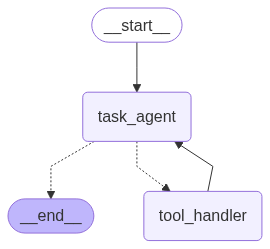

In [11]:
from langgraph.graph import StateGraph, START, END

# Build workflow
task_agent = StateGraph(State)

# Add nodes
task_agent.add_node("task_agent", task_agent_node)
task_agent.add_node("tool_handler", tool_handler)

# Add edges
task_agent.add_edge(START, "task_agent")
task_agent.add_conditional_edges(
    "task_agent",
    should_continue,
    {
        "tool_handler": "tool_handler",
        END: END,
    },
)
task_agent.add_edge("tool_handler", "task_agent")

# Compile the agent
task_agent = task_agent.compile()
display(Image(task_agent.get_graph(xray=True).draw_mermaid_png()))


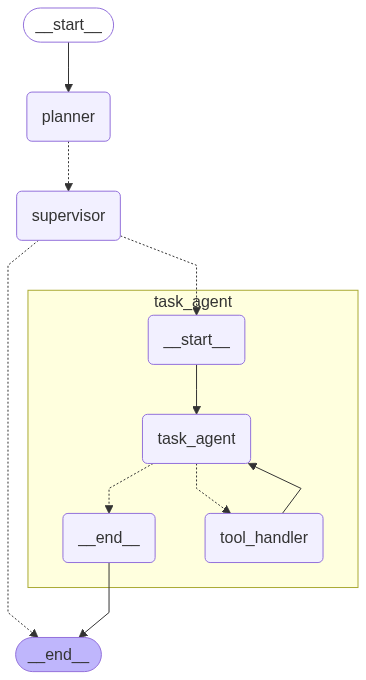

In [12]:
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()
overall_flow = StateGraph(State)

# Add nodes
overall_flow.add_node("planner", planner)
overall_flow.add_node("supervisor", supervisor)
overall_flow.add_node("task_agent", task_agent)

# Add edges
overall_flow.add_edge(START, "planner")
overall_flow.add_edge("planner", "supervisor")
overall_flow.add_conditional_edges(
    "supervisor",
    should_supervisor_end,
    {
        "task_agent": "task_agent",
        END: END,
    },
)
overall_flow.add_edge("task_agent", END)
thread_config_2 = {"configurable": {"thread_id": "1"}}

# Compile the agent
agent = overall_flow.compile(checkpointer=checkpointer)

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))


In [13]:
# response = agent.invoke({"query":"create a task , update a task and delete a task"})
# response = agent.invoke({"query":"hi"})
seen_messages = set()

for chunk in agent.stream({"query": "title is ai-agents, description use any relevant description for the given title "}, config=thread_config_2):
    for node_name, node_data in chunk.items():
        if 'messages' in node_data:
            for message in node_data['messages']:
                if hasattr(message, 'content') and message.id not in seen_messages:
                    print(message.content)
                    seen_messages.add(message.id)

Generated plans:
- Create task with title 'ai-agents' and relevant description (task_agent)
task_agent result.node
📋 Routing task 'Create task with title 'ai-agents' and relevant description' to task_agent
Creating task: ai-agents - Create a task related to AI agents, including their development, deployment, or management. Ensure the description is relevant to the context of AI agents and their applications.

✅ Task 'ai-agents' created successfully
✅ Task 'ai-agents' has been created successfully with a relevant description about AI agents, including their development, deployment, or management. If you need to update, view, or delete this task, please let me know!
